## Model Duration

In [95]:
from __future__ import division
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import sklearn.metrics
import scipy
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [69]:
df = pd.read_pickle('../data/df.pkl')

In [70]:
df_fixed = df[df['resolution_final'] == 'fixed']

In [78]:
df_fixed['duration_bin2'] = pd.qcut(df_fixed['duration_days'], 5, labels=[0,1,2,3,4])
df_fixed['duration_bin2'].value_counts()

/Users/lucka/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


0    25791
4    21991
3    21872
2    20664
1    19825
Name: duration_bin2, dtype: int64

/Users/lucka/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


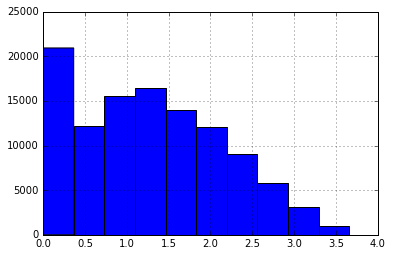

In [96]:
df_fixed['duration_days_log'] = df_fixed['duration_days'].map(lambda x: np.log10(x + 1))
df_fixed['duration_days_log'].hist()

In [74]:
df_init = df_fixed[[
    #'reporter', #not really useful, is it?
    'assigned_to_init_bool',
    'bug_status_init',
    'cc_init_cnt',
    #'component_init', #need to vectorize
    #'op_sys_init', #need to vetorize
    'priority_init', #almost always empty
    'top_product_init',
    'severity_init',
    'short_desc_init_wordcnt',
    #'short_desc_init', #NLP
    'version_init',
    #'desc_init', #NLP
    'desc_init_wordcnt',
]]

In [75]:
df_init.head(1).T

,0
assigned_to_init_bool,0
bug_status_init,1
cc_init_cnt,0
priority_init,0
top_product_init,1
severity_init,3
short_desc_init_wordcnt,3
version_init,1
desc_init_wordcnt,0


Train test split

In [99]:
X_all = df_init.values
y_all = df_fixed['duration_days_log'] #regressor
#y_all = df_fixed['duration_bin2'] #classifier

X, X_test, y, y_test = train_test_split(X_all, y_all, test_size=0.25, random_state=42)

In [100]:
print 'Majority is {}% cases in train'.format(y.value_counts().max() * 100 / y.value_counts().sum())
print 'Majority is {}% cases in test'.format(y_test.value_counts().max() * 100 / y_test.value_counts().sum())

Majority is 12.2895154164% cases in train
Majority is 12.4273678094% cases in test


### Random Forest Regressor

In [101]:
rf_model = RandomForestRegressor(n_estimators=20, criterion='mse', 
                               max_depth=3, max_features='auto', 
                               bootstrap=True, oob_score=True,
                               random_state=None, warm_start=False)

In [102]:
rf_model.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [105]:
print 'feature importances: {}'.format(rf_model.feature_importances_)
print 'oob score: {}'.format(rf_model.oob_score_)
print 'r-squared: {}'.format(rf_model.score(X_test,y_test))

feature importances: [ 0.55649836  0.22198714  0.01623514  0.01378904  0.01050099  0.05516483
  0.          0.01868148  0.10714302]
oob score: 0.0734031807501
r-squared: 0.06963286351


In [106]:
y_pred = rf_model.predict(X_test)

In [115]:
print zip(y_test.values[:20], y_pred[:20])
print (y_test.values[:20] - y_pred[:20])

[(0.6020599913279624, 1.348048070957713), (1.2304489213782739, 1.3680586766813039), (1.4913616938342726, 1.0016126754286463), (3.3287872003545345, 1.3680586766813039), (1.6532125137753437, 1.2055822654399904), (2.9143431571194407, 1.0016126754286463), (2.5740312677277188, 1.6840939443722516), (1.0, 1.3680586766813039), (2.0453229787866576, 1.3680586766813039), (0.3010299956639812, 1.3680586766813039), (3.2046625117482188, 1.3680586766813039), (1.3010299956639813, 1.0016126754286463), (1.1139433523068367, 1.0016126754286463), (1.9294189257142926, 1.3680586766813039), (0.77815125038364363, 0.90687596477487842), (1.8260748027008264, 1.2977180925974889), (1.2041199826559248, 1.3680586766813039), (0.47712125471966244, 1.3680586766813039), (2.5477747053878224, 1.3680586766813039), (2.2174839442139063, 1.3115791149951082)]
[-0.74598808 -0.13760976  0.48974902  1.96072852  0.44763025  1.91273048
  0.88993732 -0.36805868  0.6772643  -1.06702868  1.83660384  0.29941732
  0.11233068  0.56136025 -

### Multinomial NB Classifier

In [90]:
nb_model = MultinomialNB()

In [92]:
nb_model.fit(X, y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [94]:
y_pred = nb_model.predict(X_test)

print 'accuracy: {}'.format(sklearn.metrics.accuracy_score(y_test, y_pred))
print 'precision: {}'.format(sklearn.metrics.precision_score(y_test, y_pred))
print 'recall: {}'.format(sklearn.metrics.recall_score(y_test, y_pred))
print ''
print 'confusion matrix: \n {}'.format(sklearn.metrics.confusion_matrix(y_test, y_pred))

accuracy: 0.262165891923
precision: 0.225583691589
recall: 0.262165891923

confusion matrix: 
 [[4833    6   10  346 1261]
 [3426    6   11  335 1188]
 [3344    6    8  360 1395]
 [3355    6    7  398 1664]
 [3148    6   11  432 1974]]


/Users/lucka/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/lucka/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

### Random Forest Classifier

In [81]:
rf_model = RandomForestClassifier(n_estimators=20, criterion='gini', 
                               max_depth=3, max_features='auto', 
                               bootstrap=True, oob_score=True,
                               random_state=None, warm_start=False)

In [82]:
rf_model.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [83]:
y_pred = rf_model.predict(X_test)

print 'feature importances: {}'.format(rf_model.feature_importances_)
print 'oob score: {}'.format(rf_model.oob_score_)
print ''
print 'accuracy: {}'.format(sklearn.metrics.accuracy_score(y_test, y_pred))
print 'precision: {}'.format(sklearn.metrics.precision_score(y_test, y_pred))
print 'recall: {}'.format(sklearn.metrics.recall_score(y_test, y_pred))
print ''
print 'confusion matrix: \n {}'.format(sklearn.metrics.confusion_matrix(y_test, y_pred))

feature importances: [  3.41572247e-01   2.25776077e-01   8.88006250e-02   4.24235727e-02
   2.97381419e-02   3.21535479e-02   2.82741522e-04   4.65517620e-03
   2.34597871e-01]
oob score: 0.28464900069

accuracy: 0.287877687391
precision: 0.181562189074
recall: 0.287877687391

confusion matrix: 
 [[4709    1    0  972  774]
 [3222    0    0  984  760]
 [3042    0    0 1091  980]
 [2874    0    0 1234 1322]
 [2434    0    0 1153 1984]]


/Users/lucka/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/lucka/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".

### Gradient Boost Classifier

In [85]:
gb_model = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, 
                                   n_estimators=100, subsample=1.0,
                                   max_depth=3, init=None, 
                                   random_state=None, max_features=None, 
                                   verbose=0, max_leaf_nodes=None, warm_start=False)

In [86]:
gb_model.fit(X,y)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [88]:
y_pred = gb_model.predict(X_test)

print 'feature importances: {}'.format(gb_model.feature_importances_)
print ''
print 'accuracy: {}'.format(sklearn.metrics.accuracy_score(y_test, y_pred))
print 'precision: {}'.format(sklearn.metrics.precision_score(y_test, y_pred))
print 'recall: {}'.format(sklearn.metrics.recall_score(y_test, y_pred))
print ''
print 'confusion matrix: \n {}'.format(sklearn.metrics.confusion_matrix(y_test, y_pred))

feature importances: [ 0.07646832  0.09793715  0.05133819  0.04812621  0.14508496  0.10349776
  0.11900895  0.08899932  0.26953913]

accuracy: 0.297247239977
precision: 0.262224082459
recall: 0.297247239977

confusion matrix: 
 [[4150   83  110  885 1228]
 [2677   66  120  914 1189]
 [2520   54  127 1035 1377]
 [2197   57  137 1155 1884]
 [1707   44  107 1026 2687]]


/Users/lucka/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/lucka/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".